In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

C:\Users\irvin\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


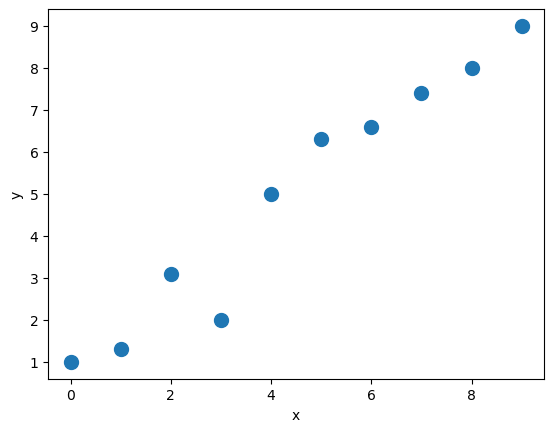

In [2]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])
plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

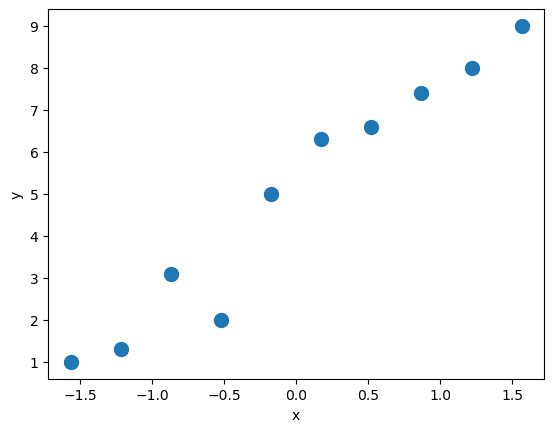

In [3]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32),
     tf.cast(y_train, tf.float32)))

plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w * x + self.b

In [5]:
model = MyModel()
# None - arbitary package size
model.build(input_shape=(None, 1))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [6]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

In [7]:
tf.random.set_seed(1)
num_of_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))

ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(batch_size)

Ws, bs = [], []
for i, batch in enumerate(ds_train):
    if i >= steps_per_epoch * num_of_epochs:
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by)
    
    train(model, bx, by, learning_rate=learning_rate)
    if i % log_steps == 0:
        print(f'Epoch {int(i / steps_per_epoch)} Step {i} loss_val {loss_val}')

Epoch 0 Step 0 loss_val 43.55999755859375
Epoch 10 Step 100 loss_val 0.7530134320259094
Epoch 20 Step 200 loss_val 20.175859451293945
Epoch 30 Step 300 loss_val 23.397605895996094
Epoch 40 Step 400 loss_val 6.348119258880615
Epoch 50 Step 500 loss_val 4.635603427886963
Epoch 60 Step 600 loss_val 0.24105073511600494
Epoch 70 Step 700 loss_val 0.20362770557403564
Epoch 80 Step 800 loss_val 3.8176910877227783
Epoch 90 Step 900 loss_val 0.9416388869285583
Epoch 100 Step 1000 loss_val 0.7034985423088074
Epoch 110 Step 1100 loss_val 0.034772761166095734
Epoch 120 Step 1200 loss_val 0.5403661131858826
Epoch 130 Step 1300 loss_val 0.11702598631381989
Epoch 140 Step 1400 loss_val 0.11948295682668686
Epoch 150 Step 1500 loss_val 0.09437620639801025
Epoch 160 Step 1600 loss_val 0.4670370817184448
Epoch 170 Step 1700 loss_val 2.0694775581359863
Epoch 180 Step 1800 loss_val 0.001972649712115526
Epoch 190 Step 1900 loss_val 0.3612426519393921


In [8]:
print('model.w:', model.w.numpy())
print('model.b:', model.b.numpy())

model.w: 2.6576622
model.b: 4.8798566


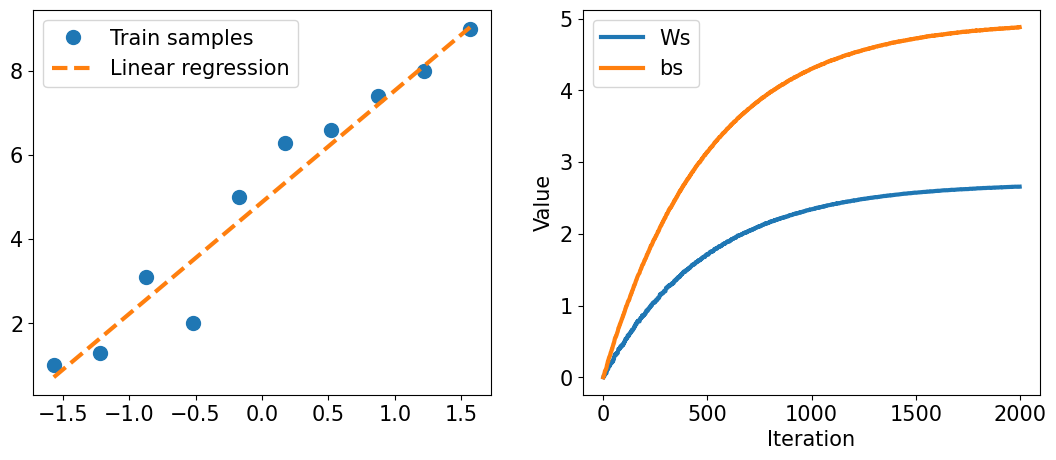

In [9]:
# reshape(-1, 1) - transform from shape (n,) to (n, 1)
X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))

fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Train samples', 'Linear regression'], fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Ws', 'bs'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [10]:
tf.random.set_seed(1)
model = MyModel()
model.compile(optimizer='sgd',
              loss=loss_fn,
              metrics=['mae', 'mse'])
model.fit(X_train_norm, y_train,
          epochs=num_of_epochs, batch_size=batch_size,
          verbose=1)

Epoch 1/200
10/10 [==============================] - 0s 1ms/step - loss: 27.8723 - mae: 4.5654 - mse: 27.8723
Epoch 2/200
10/10 [==============================] - 0s 977us/step - loss: 18.6586 - mae: 3.7446 - mse: 18.6586
Epoch 3/200
10/10 [==============================] - 0s 851us/step - loss: 12.5239 - mae: 3.0454 - mse: 12.5239
Epoch 4/200
10/10 [==============================] - 0s 928us/step - loss: 8.4670 - mae: 2.4907 - mse: 8.4670
Epoch 5/200
10/10 [==============================] - 0s 893us/step - loss: 5.7632 - mae: 2.0567 - mse: 5.7632
Epoch 6/200
10/10 [==============================] - 0s 841us/step - loss: 3.9697 - mae: 1.7232 - mse: 3.9697
Epoch 7/200
10/10 [==============================] - 0s 988us/step - loss: 2.7766 - mae: 1.4752 - mse: 2.7766
Epoch 8/200
10/10 [==============================] - 0s 892us/step - loss: 1.9861 - mae: 1.2578 - mse: 1.9861
Epoch 9/200
10/10 [==============================] - 0s 946us/step - loss: 1.4572 - mae: 1.0978 - mse: 1.4572
Epoch 

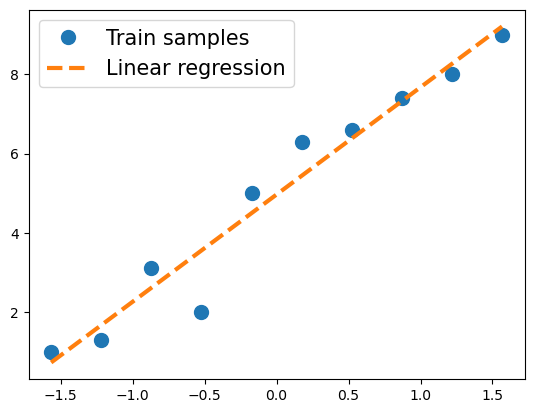

In [11]:
y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Train samples', 'Linear regression'], fontsize=15)
plt.show()

In [3]:
iris, iris_info = tfds.load('iris', with_info=True)
iris_info

tfds.core.DatasetInfo(
    name='iris',
    version=2.0.0,
    description='This is perhaps the best known database to be found in the pattern recognition
literature. Fisher's paper is a classic in the field and is referenced
frequently to this day. (See Duda & Hart, for example.) The data set contains
3 classes of 50 instances each, where each class refers to a type of iris
plant. One class is linearly separable from the other 2; the latter are NOT
linearly separable from each other.',
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=150,
    splits={
        'train': 150,
    },
    supervised_keys=('features', 'label'),
    citation="""@misc{Dua:2019 ,
    author = "Dua, Dheeru and Graff, Casey",
    year = "2017",
    title = "{UCI} Machine Learning Repository",
    url = "http://archiv

In [12]:
tf.random.set_seed(1)
ds_orig = iris['train']
print(type(ds_orig))
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)
ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)
ds_train_orig = ds_train_orig.map(lambda x: (x['features'], x['label']))
ds_test = ds_test.map(lambda x: (x['features'], x['label']))

# it = iter(ds_test)
# item = next(it)
# print('first sample features', item[0])
# print('first sample label', item[1])

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
first sample features tf.Tensor([5.7 2.5 5.  2. ], shape=(4,), dtype=float32)
first sample label tf.Tensor(2, shape=(), dtype=int64)


In [40]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, activation='softmax', name='fc2'),
])
iris_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [41]:
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [42]:
num_of_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(1000)

history = iris_model.fit(ds_train, epochs=num_of_epochs,
                         steps_per_epoch=steps_per_epoch,
                         verbose=0)

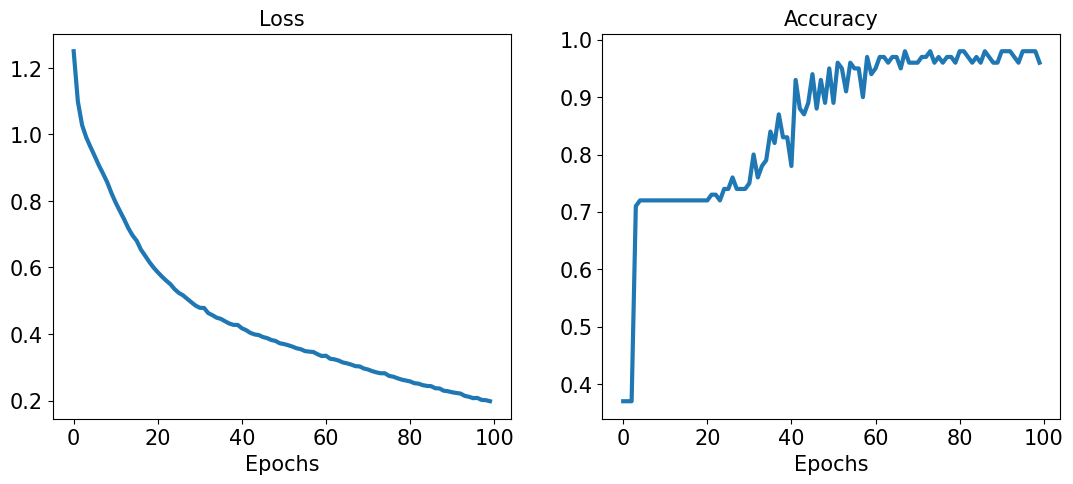

In [43]:
hist = history.history 

fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Loss', size=15)
ax.set_xlabel('Epochs', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Accuracy', size=15)
ax.set_xlabel('Epochs', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [45]:
result = iris_model.evaluate(ds_test.batch(50), verbose=0)
eval_loss, eval_acc = result
eval_loss, eval_acc

(0.2061719000339508, 0.9800000190734863)

In [46]:
iris_model.save('iris-classifier.h5',
                overwrite=True,
                include_optimizer=True,
                save_format='h5')

In [47]:
iris_model_new = tf.keras.models.load_model('iris-classifier.h5')
iris_model_new.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [48]:
result = iris_model_new.evaluate(ds_test.batch(50), verbose=0)
eval_loss, eval_acc = result
eval_loss, eval_acc

(0.2061719000339508, 0.9800000190734863)